In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os,sys
import h5py, json
import pickle as pkl
import time

sys.path.append('../PreProcessing/')
sys.path.append('../TrackingAnalyses/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF
import zone_analyses_session as ZA


In [2]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')

In [4]:
task = 'T3g'
overwrite=1

animal = 'Li'
CT_Path =  oakPaths['Clustered'] / animal / (animal+'_ClusteringSummary.json')
ZoneDat_Fn = oakPaths['Analyses'] / animal / ('{}_{}_ZoneAnalysesDat.pkl').format(animal,task)
plotSP = oakPaths['Analyses'] / animal / 'Plots'

with CT_Path.open() as f:
    CT = json.load(f)


In [7]:
CT['Sessions']
# sessions with errors for Li: 053010...

{'Li_OF_052818': 1,
 'Li_OF_052918': 1,
 'Li_OF_053018': 1,
 'Li_OF_053118': 1,
 'Li_OF_060118': 1,
 'Li_OF_060418': 1,
 'Li_OF_060518': 1,
 'Li_OF_060718': 1,
 'Li_OF_060818': 1,
 'Li_OF_061118': 1,
 'Li_OF_061218': 1,
 'Li_OF_061318': 1,
 'Li_OF_061418': 1,
 'Li_OF_061518': 1,
 'Li_OF_061818': 1,
 'Li_OF_062018': 1,
 'Li_OF_062518': 1,
 'Li_OF_062618': 1,
 'Li_OF_062718': 1,
 'Li_OF_062818': 1,
 'Li_OF_062918': 1,
 'Li_OF_070218': 1,
 'Li_OF_070618': 1,
 'Li_OF_071018': 1,
 'Li_OF_080118': 1,
 'Li_OF_080218': 1,
 'Li_T3g_052818': 1,
 'Li_T3g_052918': 1,
 'Li_T3g_053018': 1,
 'Li_T3g_053118': 1,
 'Li_T3g_060118': 1,
 'Li_T3g_060418': 1,
 'Li_T3g_061318': 1,
 'Li_T3g_061518': 1,
 'Li_T3g_061818': 1,
 'Li_T3g_062018': 1,
 'Li_T3g_062518': 1,
 'Li_T3g_062618': 1,
 'Li_T3g_062718': 1,
 'Li_T3g_062818': 1,
 'Li_T3g_070218': 1,
 'Li_T3g_070518': 1,
 'Li_T3g_070618': 1,
 'Li_T3g_070918': 1,
 'Li_T3g_071018': 1,
 'Li_T3g_071118': 1,
 'Li_T3g_072518': 1,
 'Li_T3g_072618': 1,
 'Li_T3g_073018': 

In [86]:
ZA=reload(ZA)
SF=reload(SF)
TMF=reload(TMF)
se='Cl_T3g_112318'
ZoneDat = ZA.zone_analyses(se,overwriteSpikes=overwrite,doPlots=0)


Starting Analyses for Sesssion Cl_T3g_112318
Starting Zone Analyses.
Loading Beh Tracking Data
Complete.
Binned Spikes Files not Found or overwrite=1, creating them.
Spikes Files not Found or overwrite=1, creating them.
Bin Spike File Creation and Saving Completed.
Firing Rate Files Not Found or overwrite=1, creating them.
Loading Spikes...
Binned Spike Files Loaded.
Spike File Creation and Saving Completed.
Zone Analyses Completed


In [10]:
sessionPaths = ZA.getSessionPaths(oakPaths,se)

In [14]:
PosDat = TMF.getBehTrackData(sessionPaths, overwrite=0)

Loading Beh Tracking Data
Complete.


In [20]:
SF = reload(SF)
cell_spikes, mua_spikes=SF.getSessionSpikes(sessionPaths,0)

Loaded Spike Files.


In [41]:
cell_spikes['7']

{'12': []}

In [21]:
SF = reload(SF)
resamp_t = PosDat['t']
cell_bin_spikes,cell_ids = SF.bin_TT_spikes(cell_spikes,resamp_t,origSR=sessionPaths['SR'])
mua_bin_spikes,mua_ids = SF.bin_TT_spikes(mua_spikes,resamp_t,origSR=sessionPaths['SR'])


Error processing Tetrode 7, Cluster 12
Error processing Tetrode 8, Cluster 12


In [24]:
spikes = cell_spikes
origSR=32000
orig_time = np.arange(resamp_t[0],resamp_t[-1],1/origSR)
step = resamp_t[1]-resamp_t[0]
nOrigTimePoints = len(orig_time)
nTimePoints = len(resamp_t)
sp_bins = np.zeros((spikes['nUnits'],nTimePoints))
sp_ids = {}
cnt = 0
for tt,cl_ids in spikes.items():
    if tt!='nUnits':
        for cl in cl_ids:
            try:
                sp = np.array(spikes[tt][cl])
                out_of_record_spikes = sp>=nOrigTimePoints
                if np.any(out_of_record_spikes):
                    sp = np.delete(sp,np.where(out_of_record_spikes)[0])
                sp_ids[cnt] = (tt,cl)
                #print(type(sp[0]))
                sp_bins[cnt],_ = np.histogram(orig_time[sp],bins=nTimePoints)
            except:
                print("Error processing Tetrode {}, Cluster {}".format(tt,cl))
                print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)
                pass
            cnt+=1

Error processing Tetrode 7, Cluster 12
Error <class 'IndexError'> arrays used as indices must be of integer (or boolean) type 20
Error processing Tetrode 8, Cluster 12
Error <class 'IndexError'> arrays used as indices must be of integer (or boolean) type 20


In [31]:
tt='7'
cl='12'
sp = np.array(spikes[tt][cl])
out_of_record_spikes = sp>=nOrigTimePoints
if np.any(out_of_record_spikes):
    sp = np.delete(sp,np.where(out_of_record_spikes)[0])
#print(type(sp[0]))
xx,_ = np.histogram(orig_time[sp],bins=nTimePoints)

IndexError: arrays used as indices must be of integer (or boolean) type

In [39]:
cell_spikes['6']

KeyError: '6'

In [43]:
sessionCellIDs = CT[animal]['053018']['T3g']['cell_IDs']
cell_spikes = SF.get_TT_spikes(sessionCellIDs,sessionPaths['Clusters'])

In [79]:
spikes={}
for tt_id,cl_ids in sessionCellIDs.items():
    if len(cl_ids)>0:
        ttPath = Path(sessionPaths['Clusters'],'tt_'+tt_id)
        sp_times = np.load(str(ttPath/'spike_times.npy'))
        clusters = np.load(str(ttPath/'spike_clusters.npy'))
        spikes[str(tt_id)]={}
        for cl in cl_ids:
            spikes[str(tt_id)][str(cl)]=sp_times[clusters==cl]

In [85]:
np.sum([clusters==cl][0])

3532

In [74]:
tt_id='7'
cl_ids=[12]
ttPath = Path(sessionPaths['Clusters'],'tt_'+tt_id)
sp_times = np.load(str(ttPath/'spike_times.npy'))
clusters = np.load(str(ttPath/'spike_clusters.npy'))
spikes[str(tt_id)]={}
for cl in cl_ids:
    spikes[str(tt_id)][str(cl)]=sp_times[clusters==cl].tolist()

In [78]:
spikes['7']

{'12': [[197],
  [960],
  [1117],
  [1174],
  [3254],
  [5957],
  [7775],
  [8779],
  [13791],
  [15796],
  [16241],
  [18636],
  [19659],
  [20354],
  [20492],
  [20898],
  [21429],
  [21572],
  [22116],
  [23219],
  [24628],
  [25900],
  [26039],
  [26470],
  [27502],
  [28531],
  [28656],
  [28714],
  [28717],
  [28912],
  [30586],
  [30931],
  [31418],
  [31549],
  [31729],
  [31946],
  [32763],
  [32996],
  [33574],
  [34694],
  [34935],
  [35228],
  [35800],
  [36279],
  [36716],
  [36914],
  [37864],
  [39468],
  [39828],
  [41241],
  [41508],
  [42422],
  [42761],
  [42854],
  [43069],
  [43097],
  [43150],
  [43393],
  [43953],
  [45187],
  [45481],
  [46826],
  [47675],
  [47735],
  [48057],
  [48151],
  [48922],
  [49045],
  [49274],
  [49830],
  [50347],
  [51567],
  [52348],
  [52455],
  [52506],
  [52621],
  [52804],
  [53286],
  [53534],
  [53890],
  [54256],
  [55260],
  [55393],
  [55911],
  [56601],
  [57364],
  [57689],
  [58596],
  [58735],
  [59249],
  [59450],
  [

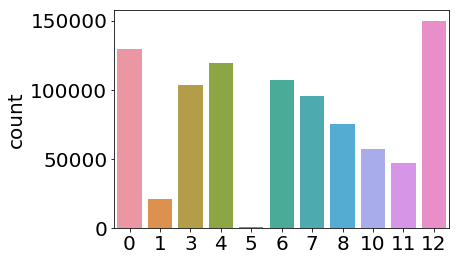

In [76]:
sns.countplot(clusters)

In [72]:
np.bincount(clusters[:,0])

array([129418,  20504,  82683, 103676, 119162,    530, 106796,  95680,
        74899,  67262,  57222,  47021])

In [58]:
for tt_id,cl_ids in sessionCellIDs.items():
    if len(cl_ids)>0:
        #print(tt_id,cl_ids)
        for cl in cl_ids:
            print(cl)

3
12
12
1
9
0


In [16]:
x,y,z = SF.getSessionBinSpikes(sessionPaths,PosDat['t'],1)

Binned Spikes Files not Found or overwrite=1, creating them.
Spikes Files not Found or overwrite=1, creating them.
Error processing Tetrode 7, Cluster 12
Error processing Tetrode 8, Cluster 12
Spike File Creation and Saving Completed.
